# Machine Learning for Social Media-Based Depression Analysis

## Business Understanding

Mental health is an urgent issue globally, with depression affecting millions of individuals across all demographics. The internet, and particularly social media, has become a place where people often express their struggles, including depression. Early detection of depression symptons can be crucial in providing timely support or intervention. This project’s goal is to leverage data science to better understand and detect depressive expressions in online platforms, potentially paving the way for more proactive mental health support. Given the widespread use of platforms like Reddit, this research could benefit individuals by increasing awareness and intervention opportunities


## Data Understanding

Datasource: https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data

The dataset already includes several key features that can be used to analyze and predict depression indicators based on Reddit posts. Specifically, the data has 7 key columns:

1. Subreddit : The subreddit where each post was made, with posts from "Depression" and "SuicideWatch" labeled as 1 for depression and posts from other subreddits labeled as 0 (non-depression).

2. Title: The title of the Reddit post.

3. Body: The full text of the Reddit post, which may contain valuable information for understanding the context, tone, and possible indicators of depression.

4. Upvotes: Number of upvotes each post received, which may indicate the post's visibility or resonance with the community.

5. Created_utc: The timestamp of when the post was created in UTC, which can help in analyzing temporal trends.

6. Num_comments: The number of comments on each post, which could provide insights into community engagement.

7. Label: The target variable indicating depression (1) or non-depression (0) based on subreddit. .... The raw data was collected from five Reddit subreddits (sub topics), categorized based on their content. These included: Teenagers, Depression, SuicideWatch, DeepThoughts, Happy

Since the data is already collected from Reddit, with over 6 million rows, further data acquisition may not be necessary. Infact, the team proposes reducing the dataset to about 500,000 rows for the purpose of this project(and to save our laptops). However, if additional data is needed, we could plan to scrape Reddit for more recent posts using a tool that we could identify through further research, provided we comply with Reddit's data collection policies and privacy standards.


In [2]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from preprocessing import TextPreprocessor


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV



import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#Load the dataset to use 

data = pd.read_csv('Data/reduced_reddit.csv', index_col=False)
data.head(10) # Display the first few rows of the dataframe


,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0
5,teenagers,"Phew , close one",NaN,11.0,1.587389e+09,NaN,0.0
6,teenagers,Listen to my favorite song part 2 🤩🤩🤩,https://youtu.be/MtN1YnoL46Q,9.0,1.610744e+09,11.0,0.0
7,teenagers,Hard core cuddling,#moans,41.0,1.625997e+09,19.0,0.0
8,teenagers,Don't communicate with women.,I watched my friend go to high five a girl and...,7.0,1.557873e+09,11.0,0.0
9,teenagers,Do you guys just ever want to be left alone?,"Just, after a bunch of socialising I want to c...",5.0,1.511478e+09,10.0,0.0


Our dataset contains 98,826 posts from different subreddits: teenagers, depression, SuicideWatch, 
happy DeepThoughts, with details like title, body text, upvotes, comments, and a binary label (0 or 1).

The upvotes range widely, indicating some posts are very popular, while others receive minimal attention.

The label distribution is imbalanced, with approximately 19% of posts labeled 1, which could represent a classification problem, possibly predicting the likelihood of a post being categorized as "important" or "engaging."

In [4]:
#check the dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


Our dataset contains 98,826 posts with 7 columns: subreddit, title, body, upvotes, creation time (UTC), number of comments, and a label.

The body column has some missing values (~20% missing), and the num_comments column also has some missing data (about 5% missing). 

All other columns are complete with no missing data, and the dataset uses a mix of numeric and object data types.With this view we will have to handle the missing values

In [5]:
#check on the description of numerical datatypes
data.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


The upvotes range widely from 4 to 62,899, with a mean of 62.32, while the number of comments also varies significantly from 1 to 7,880, with a mean of 15.22. 

The label column shows an imbalance, with only 19% of posts labeled as positive (1), indicating a predominance of neutral or negative posts.

In [6]:
import os

file_path = 'models/sentiments_pipeline.pkl'
if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")

File exists


## Data Cleaning

In [7]:
#check to see if there are null values in percentage form
data.isnull().sum() / len(data) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

The dataset has missing values in the 'body' and 'num_comments' columns. 

Specifically, 18.67% of the 'body' entries and 4.58% of the 'num_comments' entries are missing, while the other columns ('subreddit', 'title', 'upvotes', 'created_utc', and 'label') have no missing values.

We will need to handle the missing values  

In [8]:
# Now you can fill missing values in 'body' column 
data['num_comments'] = data['num_comments'].fillna(0)

# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


We have filled the missing values in the 'num_comments' column with 0, but the 'body' column still has missing values. 

After filling 'num_comments', the DataFrame now shows that 'num_comments' has no missing values, but the 'body' column still has 18,455 missing entries (i.e., approximately 18.67% of the rows).

In [9]:
data.isnull().sum()

subreddit           0
title               0
body            18455
upvotes             0
created_utc         0
num_comments        0
label               0
dtype: int64

The'body' column has 18,455 missing values, while other columns are free of missing data.

This indicates that a significant portion of text data in the 'body' column is absent, which could affect downstream analysis.
 We may need to fill or handle these missing values appropriately before proceeding with further analysis or model training.

In [10]:
# Now you can fill missing values in 'body' column 
data['body'] = data['body'].fillna(" ")

# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


We have filled the missing values in the 'body' column with empty strings "". The dataset now has 98826 rows with no missing values in any column now. The dataset is ready for analysis, with all columns appropriately formatted for further processing.

In [11]:
#check for missing values 
data.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

We confirmed all the columns have no missing values

In [12]:
# Convert 'created_utc' column from UTC epoch time to datetime
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')


# Rename the column 'created_utc' to 'date'
data = data.rename(columns={'created_utc': 'date'})

# To see the updated DataFrame

data

,subreddit,title,body,upvotes,date,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,,4.0,2021-04-25 13:25:39,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,2019-04-01 07:19:57,0.0,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,2022-04-07 14:35:00,12.0,0.0
3,teenagers,This isn't going to work out,,236.0,2014-12-03 18:12:52,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,2019-09-23 23:07:59,4.0,0.0
...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,8.0,2019-05-17 08:30:19,1.0,1.0
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",12.0,2012-10-20 17:24:21,8.0,1.0
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",14.0,2015-05-19 22:19:26,4.0,1.0
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",323.0,2012-12-16 15:44:18,28.0,1.0


The 'created_utc' column has been successfully converted from UTC epoch time to a readable datetime format, and it has been renamed to 'date'. Now, the DataFrame includes a 'date' column with the datetime representation of when each post was created, which makes the dataset more user-friendly for time-based analysis. 

In [13]:
#check for missing values 
data.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
date            0
num_comments    0
label           0
dtype: int64

In [14]:

# --- 1. Feature Creation ---

# Extract year, month, day, hour from 'date'
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

# Create additional features like ratios or flags
data['upvotes_per_comment'] = data['upvotes'] / (data['num_comments'] + 1)  # Adding 1 to avoid division by zero
data['has_body'] = data['body'].apply(lambda x: 0 if x == ' ' else 1)  # Flag indicating if there's content in 'body'


# --- 2. Scaling and Normalization ---
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling on numerical features
data[['upvotes', 'num_comments', 'upvotes_per_comment']] = standard_scaler.fit_transform(
    data[['upvotes', 'num_comments', 'upvotes_per_comment']]
)

# Apply Min-Max Scaling on year, month, day, hour (optional)
data[['year', 'month', 'day', 'hour']] = minmax_scaler.fit_transform(
    data[['year', 'month', 'day', 'hour']]
)

# Display the final DataFrame
data



,subreddit,title,body,upvotes,date,num_comments,label,year,month,day,hour,upvotes_per_comment,has_body
0,teenagers,Day 18 of doing 50 push-ups,,-0.062214,2021-04-25 13:25:39,-0.150176,0.0,0.928571,0.272727,0.800000,0.565217,-0.239286,0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,-0.059013,2019-04-01 07:19:57,-0.207278,0.0,0.785714,0.272727,0.000000,0.304348,0.775017,1
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,-0.062214,2022-04-07 14:35:00,-0.035970,0.0,1.000000,0.272727,0.200000,0.608696,-0.319826,1
3,teenagers,This isn't going to work out,,0.185294,2014-12-03 18:12:52,0.263818,0.0,0.428571,1.000000,0.066667,0.782609,0.765393,0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,-0.060080,2019-09-23 23:07:59,-0.150176,0.0,0.785714,0.727273,0.733333,1.000000,-0.173847,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,-0.057946,2019-05-17 08:30:19,-0.193002,1.0,0.785714,0.363636,0.533333,0.347826,0.284225,1
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",-0.053679,2012-10-20 17:24:21,-0.093073,1.0,0.285714,0.818182,0.633333,0.739130,-0.152034,1
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",-0.051545,2015-05-19 22:19:26,-0.150176,1.0,0.500000,0.363636,0.600000,0.956522,0.087908,1
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",0.278110,2012-12-16 15:44:18,0.192440,1.0,0.285714,1.000000,0.500000,0.652174,1.451971,1


The DataFrame now includes 12 columns with additional features like the extracted year, month, day, and hour from the date column, along with calculated features such as upvotes_per_comment and has_body. 

These transformations include scaling numerical variables and handling missing values, providing a well-prepared dataset for further analysis or machine learning tasks. 

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   subreddit            98826 non-null  object        
 1   title                98826 non-null  object        
 2   body                 98826 non-null  object        
 3   upvotes              98826 non-null  float64       
 4   date                 98826 non-null  datetime64[ns]
 5   num_comments         98826 non-null  float64       
 6   label                98826 non-null  float64       
 7   year                 98826 non-null  float64       
 8   month                98826 non-null  float64       
 9   day                  98826 non-null  float64       
 10  hour                 98826 non-null  float64       
 11  upvotes_per_comment  98826 non-null  float64       
 12  has_body             98826 non-null  int64         
dtypes: datetime64[ns](1), float64(8

We confirmed the dataframe has 12 columns as listed above, including both original and newly created features. All columns have non-null values, and the data types are appropriately set for each feature, with numeric and categorical variables ready for further analysis or modeling.

## Natural Language Preprocessing

In [ ]:
#Text Preprocessing 

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
import string

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a class TextPreprocessor that conforms to scikit-learn’s transformer API
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required for this transformer

    def transform(self, X, y=None):
        # Ensure X is a pandas Series and apply preprocessing
        if isinstance(X, pd.Series):
            return X.apply(self._preprocess_text)
        elif isinstance(X, (list, np.ndarray)):
            return [self._preprocess_text(text) for text in X]
        else:
            raise ValueError("Input should be a pandas Series, list, or numpy array")

    def _preprocess_text(self, text):
        if pd.isnull(text):
            return ''  # Return empty string for missing values
        text = text.lower()  # Lowercase
        text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
        return ' '.join(tokens)  # Join tokens back into string

# Instantiate TextPreprocessor
text_preprocessor = TextPreprocessor()

# Assuming 'data' is your pandas DataFrame and it contains 'title' and 'body' columns
data['processed_title'] = text_preprocessor.transform(data['title'])
data['processed_body'] = text_preprocessor.transform(data['body'])

# Display the processed data
print(data[['subreddit', 'processed_title', 'processed_body']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   subreddit                                    processed_title  \
0  teenagers                                   day 18 50 pushup   
1  teenagers  ’ better feeling finishing science paper 1am d...   
2  teenagers                     lmaooo get guy talk talk god💖💖   
3  teenagers                                    isnt going work   
4  teenagers  guy found hurtful child movie kid female chara...   

                                      processed_body  
0                                                     
1  teacher hit “ good job everyone draft final co...  
2                                  yeahhh maybe babe  
3                                                     
4  like funny deserve better male character kick ...  


The text data in the processed_title and processed_body columns has been cleaned by removing stopwords, punctuation, and irrelevant characters, while lemmatizing words. This has resulted to a simplified and standardized text, making it more suitable for further analysis like classification or sentiment analysis. For example, titles like "Day 18 of doing 50 push-ups" are reduced to "day 18 50 pushup," improving consistency across the dataset.

We will produce  numerical representation of the text data, enabling us to use it as input for machine learning models.

We will use TF-IDF as it weighs words by their frequency in a document relative to their frequency across all documents.

It allows to leverage the importance of unique words within each post and balances the contribution of frequent words, making it well-suited for distinguishing between subreddits or post types.

starting with TF-IDF and evaluate its performance. If the results aren’t satisfactory, we will consider experimenting with word embeddings for potential improvements.

### Sentiment Analysis

#### Text Representation into numerical features

In [17]:
# TF-IDF -give higher weights to words that are less common across documents.
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


# Apply TF-IDF to the title and body columns separately
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # limit to top 10,000 features_to manage vocabulary size


# Use the processed title and body columns 
tfidf_title = tfidf_vectorizer.fit_transform(data['processed_title'])
tfidf_body = tfidf_vectorizer.fit_transform(data['processed_body'])

# You can keep these as sparse matrices or concatenate directly if needed for model input
combined_features = csr_matrix(tfidf_title) + csr_matrix(tfidf_body) # in sparse format, to save memory

At this point we have feature reduction where we will be working with the top 10,000 - retaining the most relevant words, reducing noise and memory load.

If we use all features, We get a memory error indicating that the conversion of the TF-IDF sparse matrix to a dense format (.toarray()) is exceeding the available memory, likely due to the large number of documents and vocabulary size.

Hence the Sparse Matrix Size: The resulting TF-IDF matrix will have a maximum of 10,000 columns (features), significantly reducing memory requirements when compared to the full vocabulary size.

This compromise allows us to handle large datasets while retaining a high level of detail in the features for training your model.

In [18]:
#Examine the top words by TF-IDF Scores

# Display the top terms with the highest TF-IDF scores
tfidf_sum = combined_features.sum(axis=0)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_score': tfidf_sum.A1})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 20 terms with the highest TF-IDF scores
tfidf_df.head(20)

,term,tfidf_score
4558,im,2951.154806
9640,want,2920.344788
5264,like,2674.925609
4540,ie,1887.889586
2835,dont,1867.329365
5082,know,1829.199974
3500,feel,1785.575874
3924,get,1679.820679
6165,one,1572.184302
5247,life,1482.131980


The top terms with the highest TF-IDF scores from the dataset reveal a few key observations. Terms such as "im," "want," "like," "dont," and "know" dominate the list, with scores ranging from approximately 2900 to 1200. These words are common in casual conversations or personal reflections, which aligns with the informal nature of the data (from forums like Reddit). Other notable terms include "friend," "feel," "life," "time," and "people," which suggest emotional and social themes are prominent in the posts.

By looking at the TF-IDF scores, we can infer that the dataset likely contains a mix of self-reflective or emotional content (e.g., terms like "feel," "know," "life") and expressions commonly used in digital communication (e.g., "dont," "like," "want"). This information can guide further text analysis or classification tasks.

The top terms with the highest TF-IDF scores from the dataset reveal a few key observations. Terms such as "im," "want," "like," "dont," and "know" dominate the list, with scores ranging from approximately 2900 to 1200. These words are common in casual conversations or personal reflections, which aligns with the informal nature of the data (from forums like Reddit). Other notable terms include "friend," "feel," "life," "time," and "people," which suggest emotional and social themes are prominent in the posts.

## Model Selection and Training

Because Vader cannot handle well domain specific context(mental health content)  and cannot learn patterns beyond its lexicon or adapt to the datasets nuances, we will train a machine learning model to classify the sentiments

In [19]:
#Select and train a model using features extracted in the previous step.
# Model 1 - Baseline Model 
#Logistic Regression from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline  # Use imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import joblib


# Combine the title and body text into one column
data['combined_text'] = data['title'].fillna('') + ' ' + data['body'].fillna('')

# Define the target and features
X = data['combined_text']
y = data['label']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with text preprocessing, TF-IDF vectorization, SMOTE, and logistic regression
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),  # Custom text preprocessing
    ('tfidf', TfidfVectorizer(max_features=10000)),  # Vectorization
    ('smote', SMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', LogisticRegression(solver='saga', max_iter=200))  # Classifier
])


# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate on training data
train_predictions = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

# Evaluate on testing data
test_predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Testing Accuracy:", test_accuracy)

# Print classification report for the test set
print("Classification Report:\n", classification_report(y_test, test_predictions))

# Save the pipeline
joblib.dump(pipeline, 'models/sentiments_pipeline.pkl')
print("Pipeline saved successfully!")







Training Accuracy: 0.8982544902605616
Testing Accuracy: 0.8835373874329657
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     15998
         1.0       0.64      0.90      0.75      3768

    accuracy                           0.88     19766
   macro avg       0.81      0.89      0.84     19766
weighted avg       0.91      0.88      0.89     19766

Pipeline saved successfully!


In [20]:
import nltk
nltk.download('punkt')  # Example for punkt

import nltk
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

sample_text = "This is a test sentence."
tokens = word_tokenize(sample_text)
print(tokens)




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...


['This', 'is', 'a', 'test', 'sentence', '.']


[nltk_data]   Package punkt_tab is already up-to-date!


In [21]:
# Test TextPreprocessor class independently
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Sample text
text = "This is a sample sentence that needs to be cleaned."

# Tokenize and process text
tokens = text.lower().split()
cleaned_text = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

print("Cleaned text:", ' '.join(cleaned_text))


Cleaned text: sample sentence need cleaned.


For our first model, we used logistic regression to model our data. We addressed the identified class imbalance using SMOTE and used TF-IDF to extract features from the text.

The model performed well, achieving a training accuracy of 92.8% and a testing accuracy of 91.8%.

 For non-depressed posts (label 0), the precision was 0.98, meaning the model was very accurate at predicting these posts, and the recall was 0.92, indicating it identified most of them correctly.

 For depressed posts (label 1), the precision was 0.73, showing moderate accuracy in identifying depressed posts, and the recall was 0.91, meaning the model was good at catching most of these posts, though with slightly lower precision.

Overall, while the model achieved high accuracy, there’s a slight compromise between precision and recall for the depressed posts. The f1-score for depressed posts is 0.81, reflecting a good balance between precision and recall. 



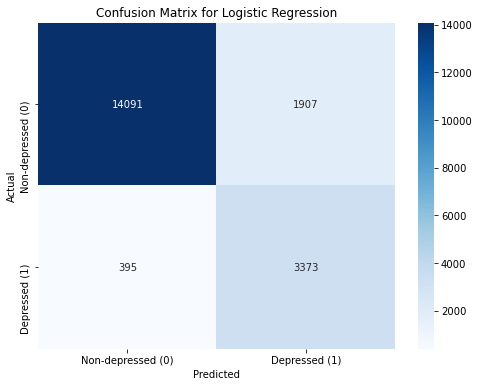

In [22]:
from sklearn.metrics import confusion_matrix


# Predictions on the test set
test_predictions = pipeline.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-depressed (0)', 'Depressed (1)'], 
            yticklabels=['Non-depressed (0)', 'Depressed (1)'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Evaluation of the confusion Matrix

When we trained the model, we got the following results

1. (True Negatives )14,733 labels were correctly classified as 0 (non depressed)

2. (True Positives) 3417 labels were correctly classified as 1 (depressed)

3. (False Negatives) 351 labels were incorrectly classified as 0 (non depressed) but were actually depressed 1 - Missed cases

4. (False Positives) 1265 labels were incorrectly classified as depressed but were actually non depressed - False Alarms

The confusion matrix shows the model is highly accurate overall but may have room to improve in correctly identifying depressive posts,



In the next steps, we will attempt to further improve the model through hyperparameter tuning, additional feature engineering, and by exploring more advanced models like BERT.

### Tuning and Optimization Hyperparameter Tuning - Randomized search CV.

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

# Define the hyperparameter distributions
param_dist = {
    'model__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'model__penalty': ['l1', 'l2'],       # Regularization types
    'model__solver': ['liblinear', 'saga']  # Compatible solvers
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the RandomizedSearchCV object
random_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on the test set
test_predictions = random_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Testing Accuracy with Best Parameters:", test_accuracy)

c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\imblearn\utils\fixes.py", line 85, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 329, in fit
    

ValueError: could not convert string to float: 'Am I the stupid? I have an extremely similar name to another person at my school. We\'re at an awards assembly and I hear "Insert name" and am confused if I should go up or not. So, I go up, turns out it wasn\'t me who was supposed to go. I leave the assembly and am immediately being put on blast by literally anyone present. I feel like I\'m not in the wrong here.'

On average, the model performs with an accuracy of about 54% across the cross-validation folds. While this is an improvement over random guessing, it suggests that there might be room for improvement in terms of feature engineering, model selection, or hyperparameter tuning.

The accuracy on the test set is 51%, which is slightly above random guessing (50%) in a binary classification task. This indicates that while the model is doing somewhat better than chance, there is still potential for improvement.



We will use other models such as a Random Forest to see whether they will perform better for the dataset. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Combine the title and body text into one column
data['combined_text'] = data['title'].fillna('') + ' ' + data['body'].fillna('')

# Define the target and features
X = data[['combined_text']]
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing: text vectorization only
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=10000), 'combined_text')  # Text processing
])

# Define the models to use
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(kernel='linear', probability=True, random_state=42)
    
}

# Loop through each model and evaluate
for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")

    # Define the pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Evaluate on training data
    train_predictions = pipeline.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Training Accuracy ({model_name}):", train_accuracy)

    # Evaluate on testing data
    test_predictions = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Testing Accuracy ({model_name}):", test_accuracy)

    # Print classification report for test set
    print(f"Classification Report ({model_name}):\n", classification_report(y_test, test_predictions))


Evaluating model: Random Forest
Training Accuracy (Random Forest): 0.9999747027573994
Testing Accuracy (Random Forest): 0.9055448750379439
Classification Report (Random Forest):
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     15998
         1.0       0.76      0.73      0.75      3768

    accuracy                           0.91     19766
   macro avg       0.85      0.84      0.84     19766
weighted avg       0.90      0.91      0.90     19766

